In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA, PCA, NMF
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from collections import Counter
import time, csv

from util import load_data

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

In [2]:
def timerDecorator(function):
    def wrapper(*args, **kwargs):
        t0 = time.time()
        out = function(*args, **kwargs)
        t1 = time.time()
        print("Function \"%s\" took %f s" % (function.__name__, (t1 - t0)))
        return out
    return wrapper



In [3]:
def plotReconstructionError(results, filename=None, save_csv=True):
    N = len(results) + 1
    ind = np.arange(1, N)
    width = 0.5
    fig, ax = plt.subplots()
    thr1 = 0.1
    thr2 = 0.25

    # resultsMax = max(results)
    # results = [n / resultsMax for n in results]

    rects = ax.bar(ind, height=results, width=width, color='b')
    ax.set_title(filename)
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Average Reconstruction Error")
    ax.set_xticks(range(0, N, 4))
#     ax.plot((0, N), (thr1, thr1), 'r-')
#     ax.plot((0, N), (thr2, thr2), 'm-')
#     ax.grid()
#     if filename is not None:
#         plt.savefig(filename+"")
#     else:
#         plt.show()
#     if save_csv:
#         with open(filename+".csv", 'w') as f:
#             w = csv.writer(f)
#             w.writerow(("included", "average error"))
#             for e in zip(range(1, N), results):
#                 w.writerow(e)


In [4]:
@timerDecorator
def runPCARoutine(data, name):
    dn = data.shape[0]*data.shape[1]
    pca = PCA(n_components=data.shape[1], random_state=RANDOM_STATE)
    pca.fit(data)

    results = []
    for i in range(data.shape[1]):
        curVariances = pca.components_[:i+1]
        transform = np.dot(data - pca.mean_, curVariances.T)
        transformInverse = np.dot(transform, curVariances) + pca.mean_
        mse = (np.sum((data - transformInverse)**2) / dn)**0.5
        results.append(mse)

    plotReconstructionError(results, filename="PCA_"+name)

In [5]:
@timerDecorator
def runICARoutine(data, name):
    dn = data.shape[0]*data.shape[1]

    results = []
    for i in range(data.shape[1]):
        ica = FastICA(n_components=i+1, random_state=RANDOM_STATE, max_iter=1000)
        transform = ica.fit_transform(data)
        transformInverse = ica.inverse_transform(transform)
        mse = (np.sum((data - transformInverse)**2) / dn)**0.5
        # print(i, mse)
        results.append(mse)

    plotReconstructionError(results, filename="ICA_"+name)

In [6]:
@timerDecorator
def runRPRoutine(data, name):
    dn = data.shape[0]*data.shape[1]

    results = []
    for i in range(data.shape[1]):
        rp = GaussianRandomProjection(n_components=i+1, random_state=RANDOM_STATE)
        rp.fit_transform(data)
        curVariances = rp.components_
        transform = np.dot(data, curVariances.T)
        transformInverse = np.dot(transform, curVariances)
        mse = (np.sum((data - transformInverse)**2) / dn)**0.5
        results.append(mse)

    plotReconstructionError(results, filename="RPR_"+name)


In [7]:
@timerDecorator
def runNMFoutine(data, name):
    dn = data.shape[0]*data.shape[1]

    results = []
    for i in range(data.shape[1]):
        pg = NMF(n_components=i+1, random_state=RANDOM_STATE)
        transform = pg.fit_transform(data)
        transformInverse = pg.inverse_transform(transform)
        mse = (np.sum((data - transformInverse)**2) / dn)**0.5
        # print(i, mse)
        results.append(mse)

    plotReconstructionError(results, filename="NMF_"+name)

In [8]:
digits = load_data.DigitsData("data/digits/optdigits.tra").getData()[0]
digitsTest = load_data.DigitsData("data/digits/optdigits.tes").getData()[0]
adult = np.genfromtxt("data/adult/ohe_adult.csv", delimiter=",", dtype=float)
print(adult.shape)
np.random.shuffle(adult)
nadult = normalize(adult[:, -7:-1], axis=0)
adult = (np.concatenate((adult[:, :-7], nadult), axis=1), adult[:, -1])
print(adult[0].shape)

(32561, 109)
(32561, 108)


Function "runPCARoutine" took 5.400370 s
Function "runRPRoutine" took 4.851341 s


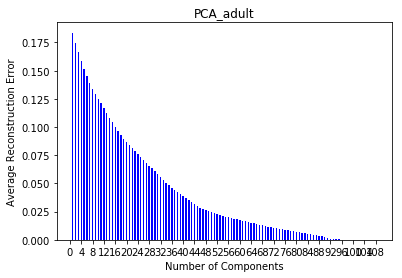

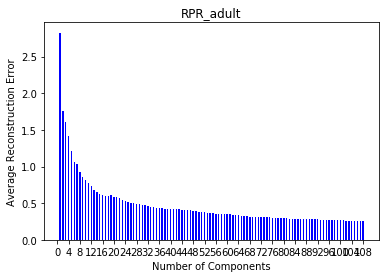

In [9]:
runPCARoutine(adult[0], "adult")
runRPRoutine(adult[0], "adult")

Function "runPCARoutine" took 0.188413 s
Function "runRPRoutine" took 0.338788 s


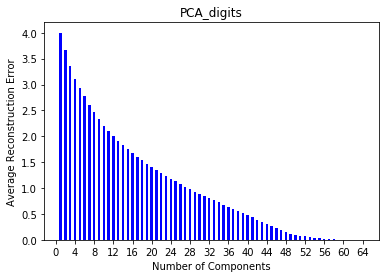

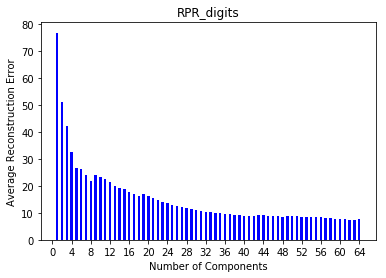

In [10]:
runPCARoutine(digits[0], "digits")
runRPRoutine(digits[0], "digits")

In [20]:
def runNN(trExampleVector, trFormattedTargetsVector, teExampleVector, teTargetVector):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=RANDOM_STATE, hidden_layer_sizes=(20,20,20), verbose=True)
    fitStartTime = time.time()
    clf.fit(trExampleVector, trFormattedTargetsVector)
    fitElapsedTime = time.time() - fitStartTime

    prediction = clf.predict(teExampleVector)
    numCorrect = 0
    
    iterable=False
    try:
        iter(prediction[0])
        iterable=True
    except:
        pass
    
    if iterable:
        for ndx in range(len(teExampleVector)):
            if sum(prediction[ndx] - teTargetVector[ndx]) == 0:
                numCorrect += 1
    else:
        for ndx in range(len(teExampleVector)):
            if prediction[ndx] == teTargetVector[ndx]:
                numCorrect += 1

    accuracy = (float(numCorrect) / len(teTargetVector))**0.5
    result = [accuracy, fitElapsedTime, fitElapsedTime / 60]
    return result

In [21]:
def oneHotLabels(labels, i=10):
    encoding = []
    for label in labels:
        zeroVector = [0]*i
        zeroVector[int(label)] = 1
        encoding.append(zeroVector)

    return encoding

In [25]:
@timerDecorator
def runNNexp(comprange, dimRedAlg, trainEx, trainLabels, testEx, testLabels):
    results = {'numcomp':[],'acc':[],'time':[],'timeMin':[]}
    for numcomp in comprange:
        dimRed = dimRedAlg(n_components=numcomp, random_state=RANDOM_STATE)
        redTrainEx = dimRed.fit_transform(trainEx)
        redTestEx = dimRed.transform(testEx)
        r = runNN(redTrainEx, trainLabels, redTestEx, testLabels)
        results['numcomp'].append(numcomp)
        results['acc'].append(r[0])
        results['time'].append(r[1])
        results['timeMin'].append(r[2])
#         print(numcomp)
    return results    

In [26]:
oheDigitsTrain = oneHotLabels(digits[1])
oheDigitsTest = oneHotLabels(digitsTest[1])

Function "runNNexp" took 36.520656 s


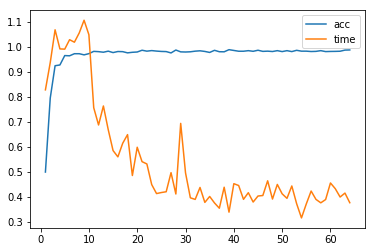

In [27]:
results1 = runNNexp(range(1,65), PCA, digits[0], oheDigitsTrain, digitsTest[0], oheDigitsTest)
df = pd.DataFrame(results1)
plt.plot('numcomp', 'acc', data=df)
plt.plot('numcomp', 'time', data=df)
plt.legend()


Function "runNNexp" took 61.401926 s


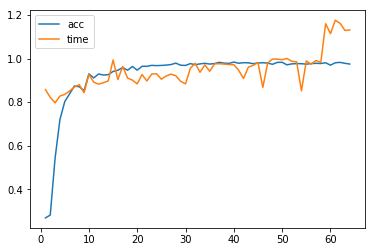

In [28]:
results2 = runNNexp(range(1,65), GaussianRandomProjection, digits[0], oheDigitsTrain, digitsTest[0], oheDigitsTest)
df = pd.DataFrame(results2)
plt.plot( 'numcomp', 'acc', data=df)
plt.plot( 'numcomp', 'time', data=df)
plt.legend()


In [29]:
adultTrainEx = adult[0][:20000]
adultTestEx = adult[0][20000:]
adultTrainLabels = adult[1][:20000]
adultTestLabels = adult[1][20000:]

print(adultTrainEx.shape)
print(adultTestEx.shape)
print(adultTrainLabels.shape)
print(adultTestLabels.shape)

(20000, 108)
(12561, 108)
(20000,)
(12561,)


In [35]:
results3 = runNNexp(range(1,109,3), PCA, adultTrainEx, adultTrainLabels, adultTestEx, adultTestLabels)

Function "runNNexp" took 196.600925 s


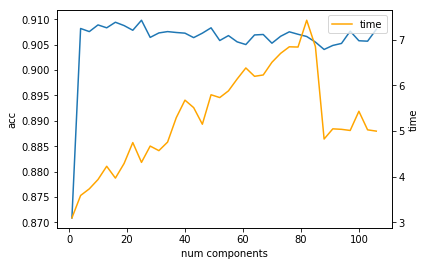

In [44]:
df = pd.DataFrame(results3)
fig, ax1 = plt.subplots()
ax1.plot('numcomp', 'acc', data=df)
ax1.set_xlabel('num components')
ax1.set_ylabel('acc')
ax2 = ax1.twinx()
ax2.plot('numcomp', 'time', data=df, color='orange')
ax2.set_ylabel('time')
plt.legend()

In [45]:
results4 = runNNexp(range(1,109,3), GaussianRandomProjection, adultTrainEx, adultTrainLabels, adultTestEx, adultTestLabels)

Function "runNNexp" took 141.303611 s


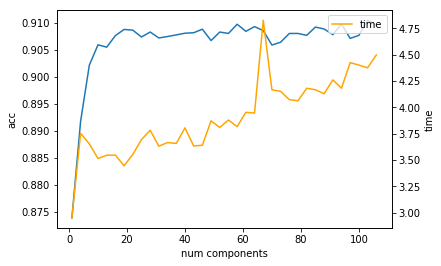

In [46]:
df = pd.DataFrame(results4)
fig, ax1 = plt.subplots()
ax1.plot('numcomp', 'acc', data=df)
ax1.set_xlabel('num components')
ax1.set_ylabel('acc')
ax2 = ax1.twinx()
ax2.plot('numcomp', 'time', data=df, color='orange')
ax2.set_ylabel('time')
plt.legend()